# IMPORTING LIBRARIES

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from catboost import CatBoostRegressor
import pylab
import openrouteservice
import json

# 1. PROBLEM STATEMENT

At some point or the other almost each one of us has used an Ola or Uber for taking a ride.

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.


To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

# 2. LOADING DATASET

In [2]:
df = pd.read_csv("nyc_taxi_trip_duration.csv")

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

# 3. PRE EDA EDITING

#### MISSING VALUE

In [4]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### DROPPING COLUMNS NOT IN TEST

In [5]:
df = df.drop(["dropoff_datetime", "store_and_fwd_flag"], axis=1)

#### GETTING EXTRA FEATURES FROM DATE COLUMN

In [6]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

In [7]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,day_of_week,hour_of_day
0,id1080784,2,2016-02-29 16:40:21,1,-73.953918,40.778873,-73.963875,40.771164,400,2,0,16
1,id0889885,1,2016-03-11 23:35:37,2,-73.988312,40.731743,-73.994751,40.694931,1100,3,4,23
2,id0857912,2,2016-02-21 17:59:33,2,-73.997314,40.721458,-73.948029,40.774918,1635,2,6,17
3,id3744273,2,2016-01-05 09:44:31,6,-73.961670,40.759720,-73.956779,40.780628,1141,1,1,9
4,id0232939,1,2016-02-17 06:42:23,1,-74.017120,40.708469,-73.988182,40.740631,848,2,2,6


# 4. EDA

In [8]:
cont_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']
cat_cols = ['vendor_id', 'passenger_count']
date_based_cols = ['month','day_of_week', 'hour_of_day']

## 4.1 UNIVARIATE ANALYSIS

#### UNIVARIATE CONTINOUS

In [9]:
def uni_cont(df):
    plt.figure(figsize=(20, 5))
    mini = df.min()[0]
    maxi = df.max()[0]
    mean = df.mean()[0]
    median = df.median()[0]
    std = df.std()[0]
    skew = df.skew()[0]
    kurtosis = df.kurtosis()[0]
    sns.kdeplot(df.squeeze())
    sns.scatterplot([mean], [0], color="red", label="mean", s=200)
    sns.scatterplot([median], [0], color="blue", label="median", s=200)
    sns.scatterplot([mini, maxi], [0, 0], color="green", label="min/max", s=200)
    plt.ylabel("density")
    plt.xlabel(df.columns[0])
    plt.title("{} | min = {} | max = {} | std = {} | kurtosis = {} | skew = {} | mean = {} | median = {}".format(df.columns[0], round(mini,2), round(maxi,2), round(std,3), round(kurtosis,3), round(skew,3), round(mean,3), round(median,3)))

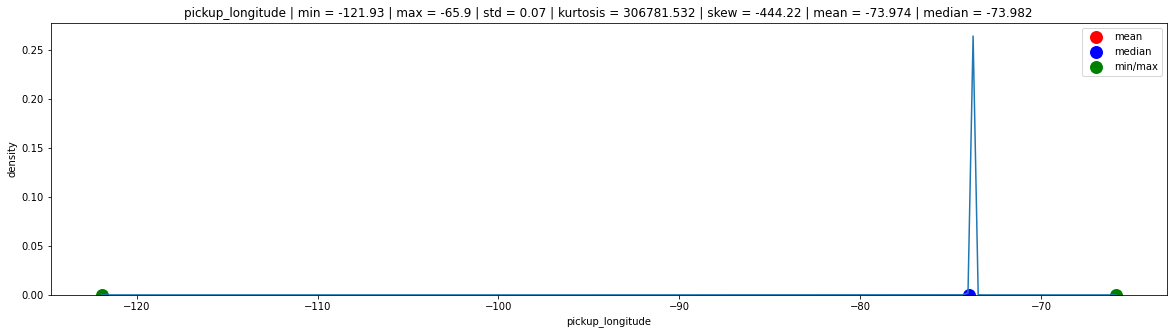

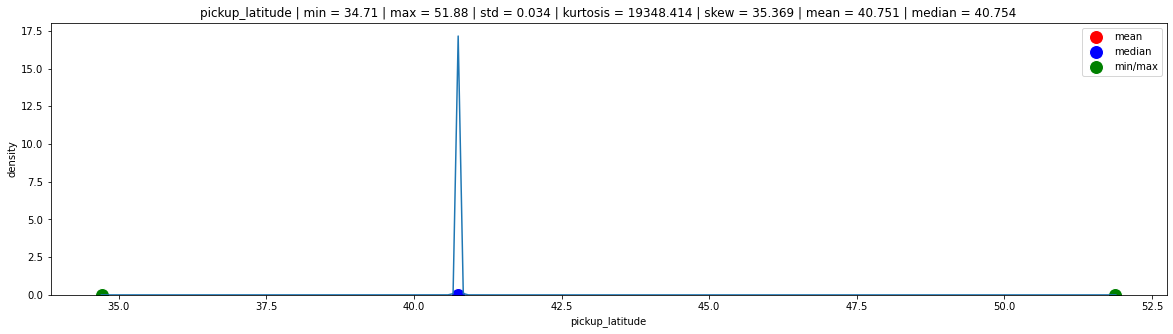

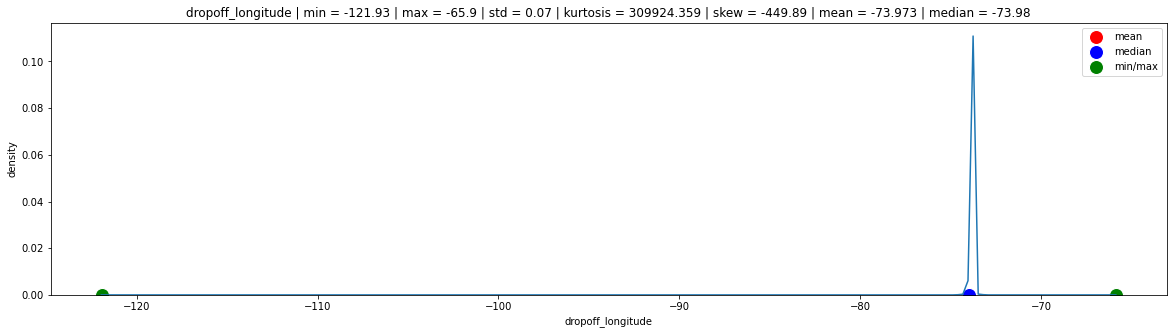

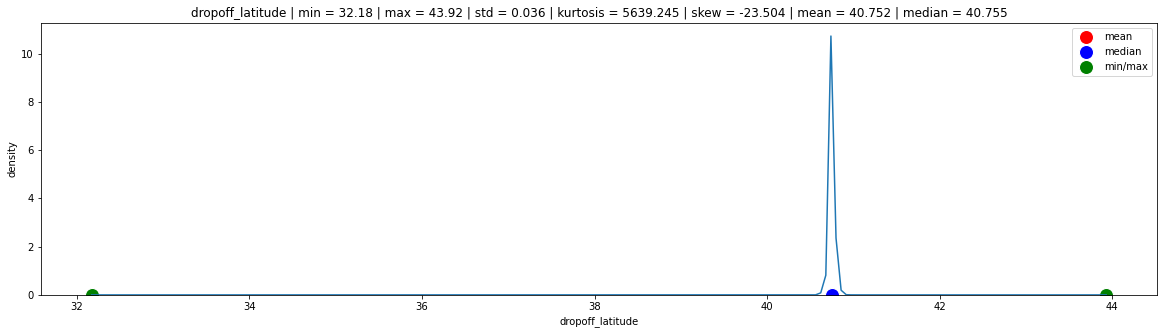

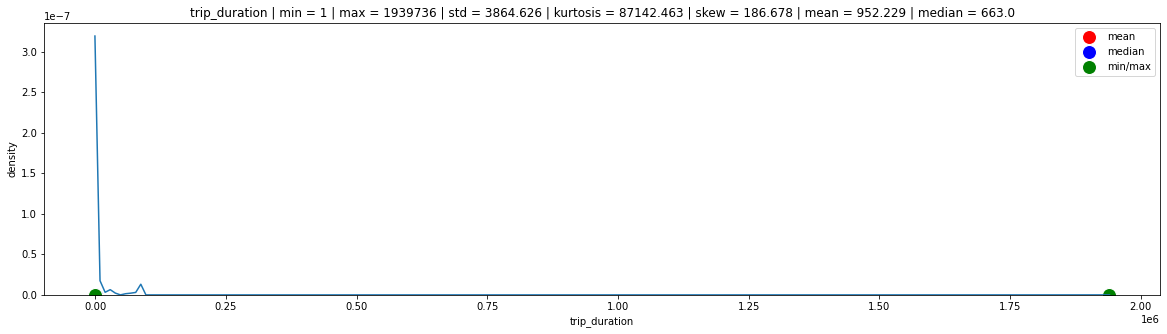

In [10]:
for i in cont_cols:
    uni_cont(df[[i]])

#### OUTLIER

In [11]:
def outlier(df):
    plt.figure(figsize =(5, 5))
    IQR = df.quantile(0.75) - df.quantile(0.25)
    MAX = df.quantile(0.75) + (1.5 * IQR)
    MIN = df.quantile(0.25) - (1.5 * IQR)
    plt.title(i + "  |  outliers = " + str(round(df[(df[[i]] > MAX) | (df[[i]] < MIN)].count()[0] / len(df) * 100, 2)) + "%")
    plt.boxplot(df[i])

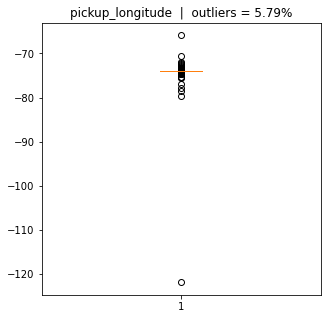

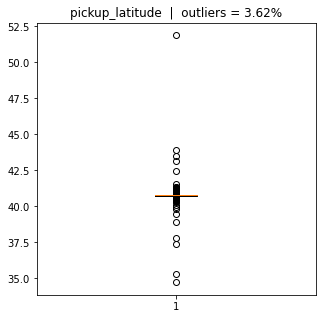

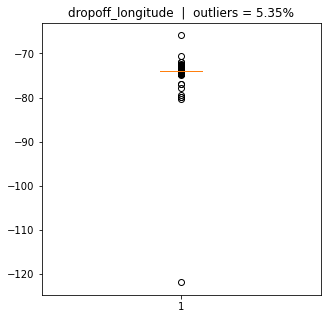

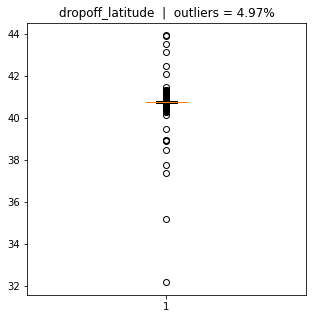

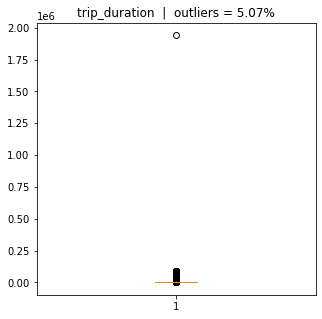

In [12]:
for i in cont_cols:
    outlier(df[[i]])

#### UNIVARIATE CATEGORICAL

In [13]:
def uni_cat(df):
    plt.figure(figsize=(20, 5))
    summary = pd.DataFrame(df.groupby(df.columns[1])['id'].count())
    summary.reset_index(inplace = True)
    b = sns.barplot(list(summary.values[:,0]), list(summary.values[:,1]))
    for index, row in summary.iterrows():
        b.text(row.name, row.id, str(row.id) + " : " + str(round((row.id*100)/df.shape[0], 2)) + "%", color='black', ha="center")
    plt.title(df.columns[1])
    plt.xlabel(df.columns[1])
    plt.ylabel('count')
    plt.show()

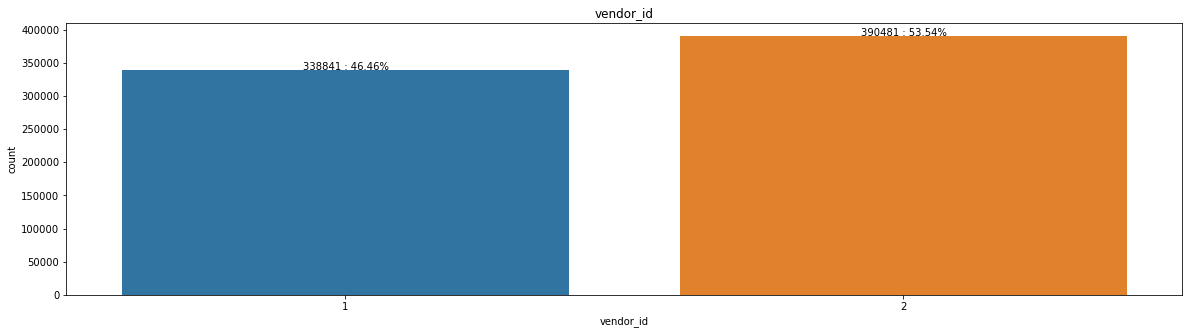

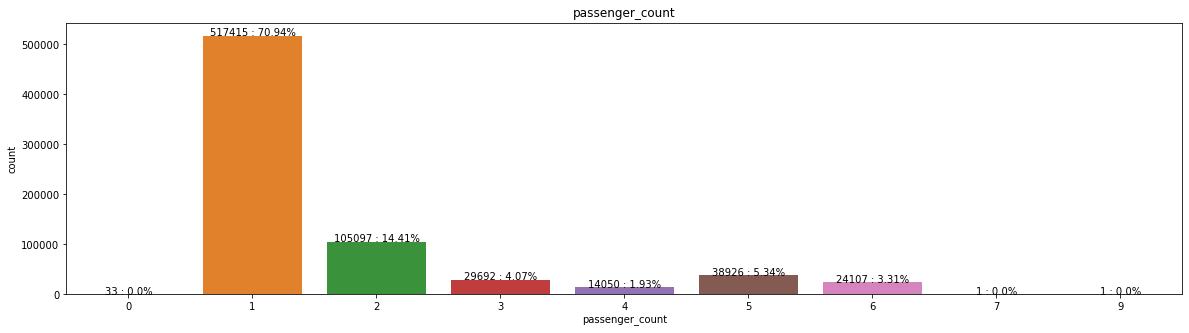

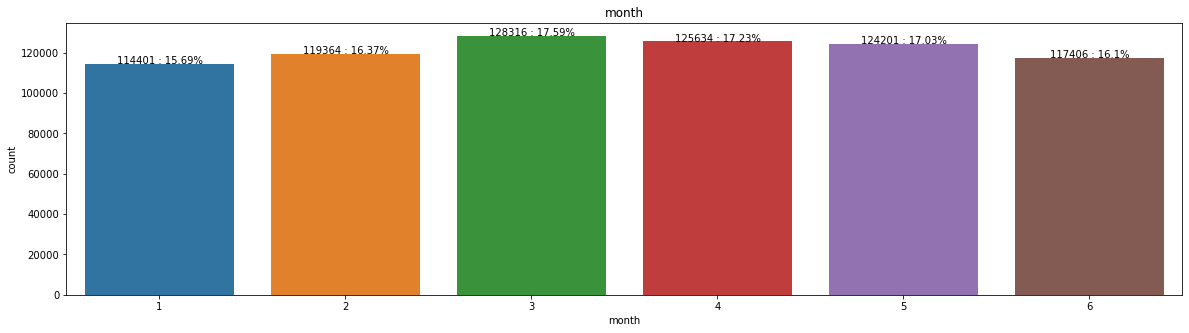

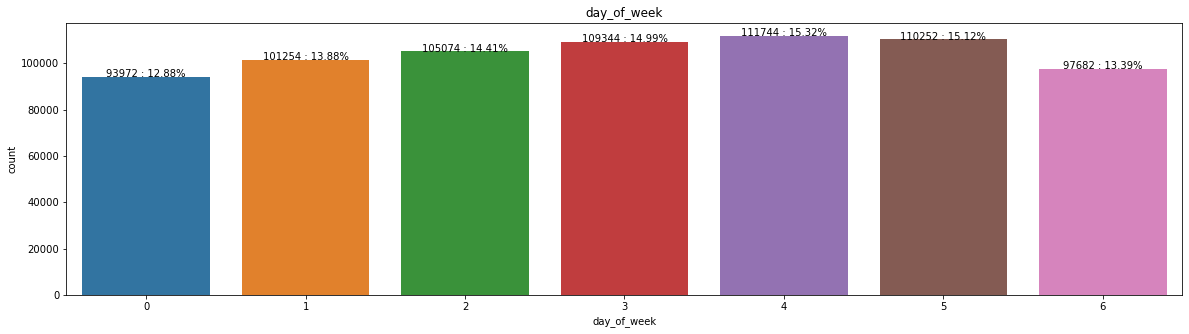

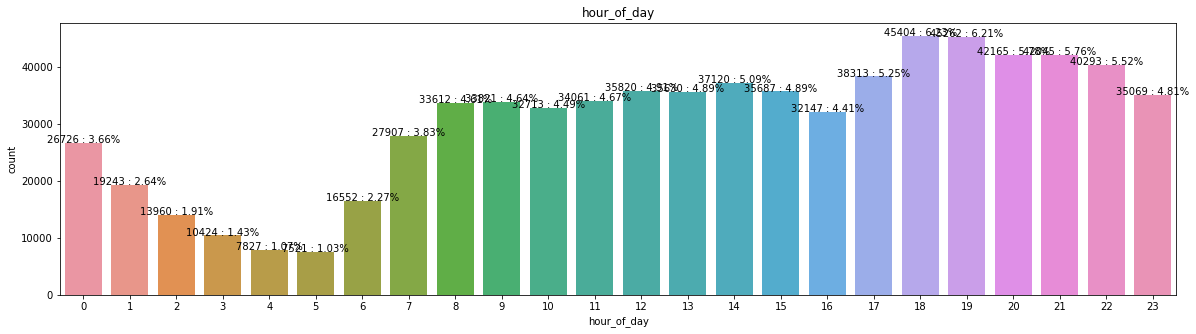

In [14]:
for i in cat_cols + date_based_cols:
    uni_cat(df[['id', i]])

## 4.2 BIVARIATE ANALYSIS

#### CONTINOUS - CONTINOUS

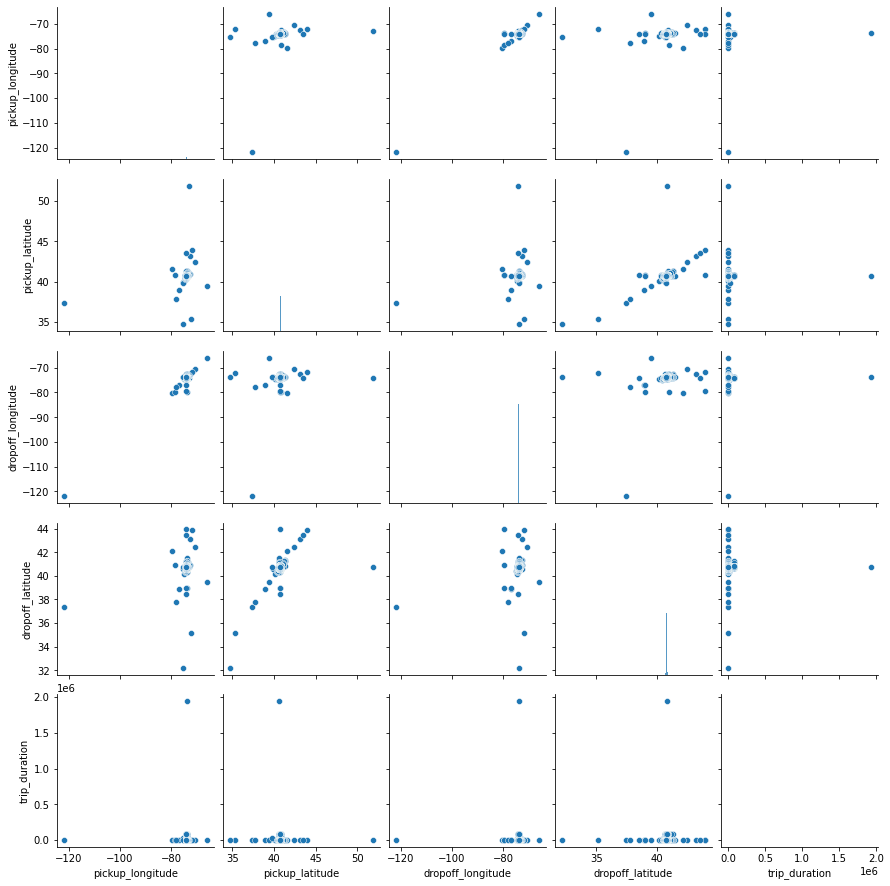

In [15]:
sns.pairplot(df[cont_cols])

#### CATEGORICAL - CONTINOUS

In [16]:
def cat_cont(df):
    plt.figure(figsize=(20, 5))
    summary = pd.DataFrame(df.groupby(df.columns[1])['trip_duration'].median())
    summary.reset_index(inplace = True)
    b = sns.barplot(list(summary.values[:,0]), list(summary.values[:,1]))
    for index, row in summary.iterrows():
        b.text(row.name, row.trip_duration, row.trip_duration, color='black', ha="center")
    plt.title(df.columns[1])
    plt.xlabel(df.columns[1])
    plt.ylabel(df.columns[0])
    plt.show()

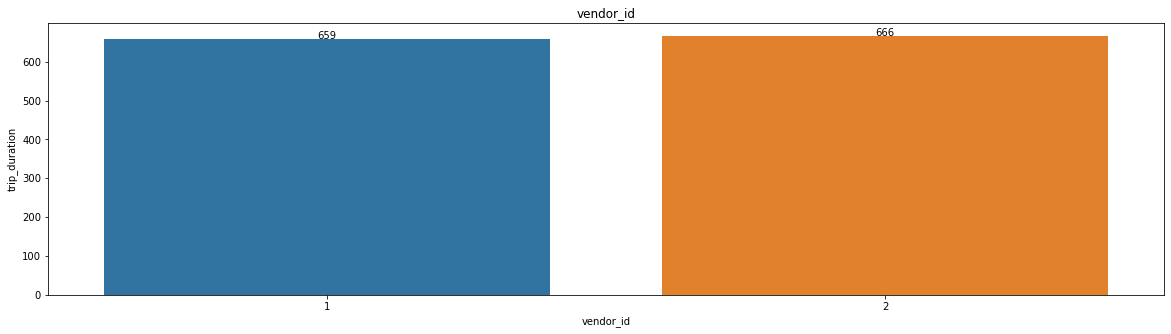

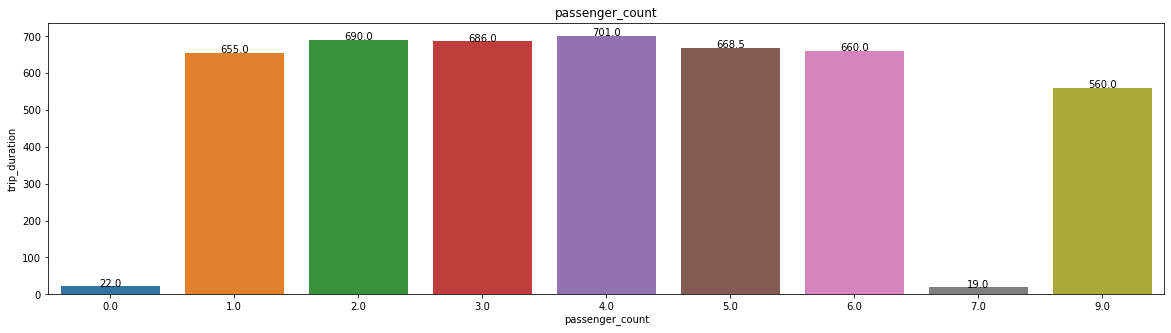

In [17]:
for i in cat_cols:
    cat_cont(df[["trip_duration", i]])

#### DATE BASED - CONTINOUS

In [18]:
def date_based_cont(df):
    plt.figure(figsize=(20, 5))
    summary = pd.DataFrame(df.groupby(df.columns[1])['trip_duration'].median())
    summary.reset_index(inplace = True)
    summary = summary.sort_values(df.columns[1])
    sns.lineplot(data=summary, x=i, y="trip_duration")
    plt.title(df.columns[1])
    plt.xlabel(df.columns[1])
    plt.ylabel(df.columns[0])
    plt.show()

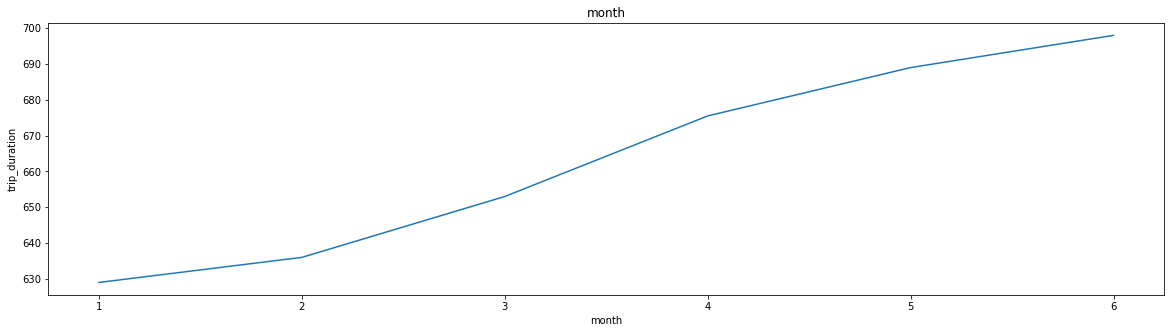

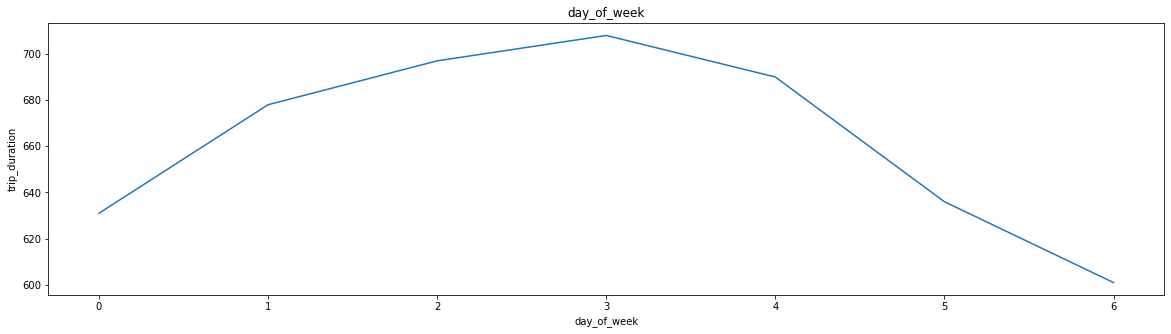

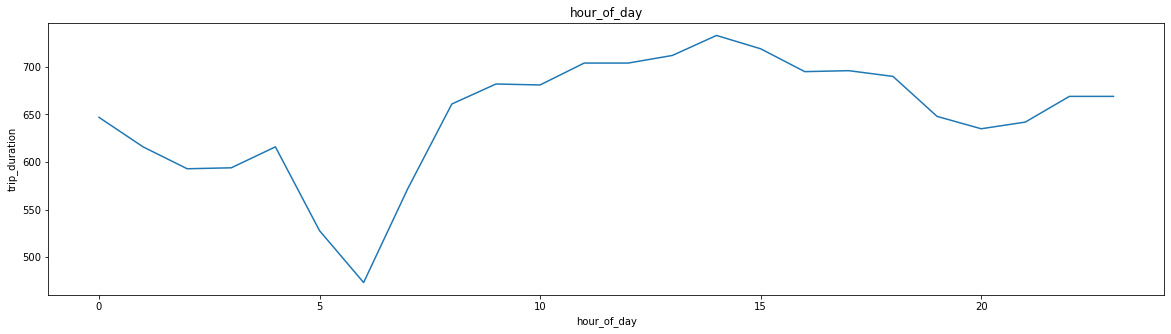

In [19]:
for i in date_based_cols:
    date_based_cont(df[["trip_duration", i]])

# 5. FEATURE ENGINEERING

#### REMOVE OUTLIER

In [8]:
for i in cont_cols:
    IQR = df[i].quantile(0.75) - df[i].quantile(0.25)
    MAX = df[i].quantile(0.75) + (1.5 * IQR)
    MIN = df[i].quantile(0.25) - (1.5 * IQR)
    df = df[(df[i] > MIN) & (df[i] < MAX)]

NameError: name 'cont_cols' is not defined

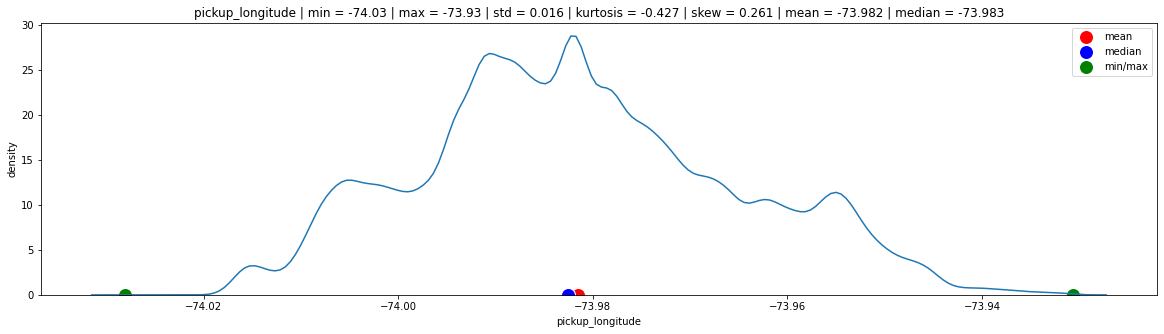

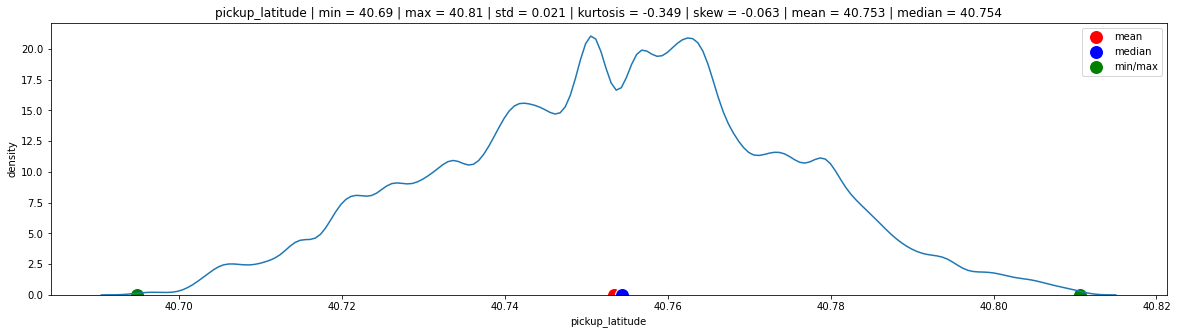

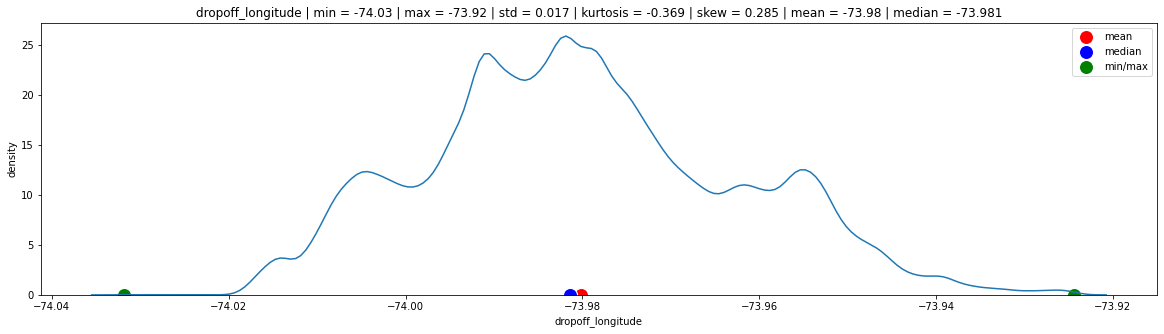

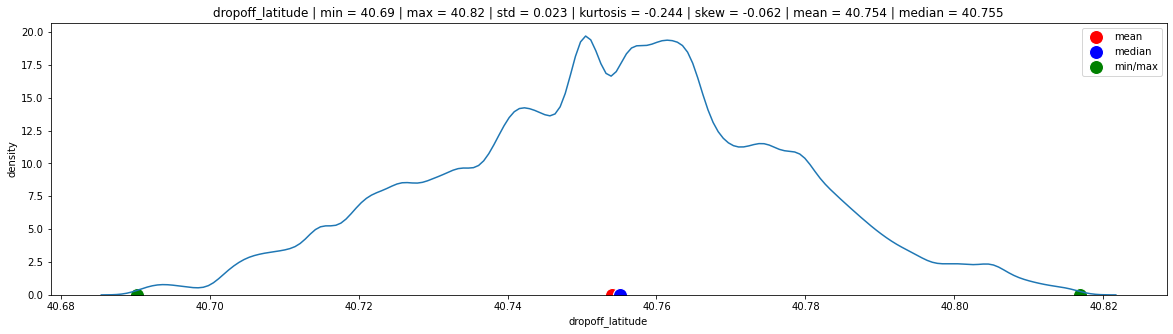

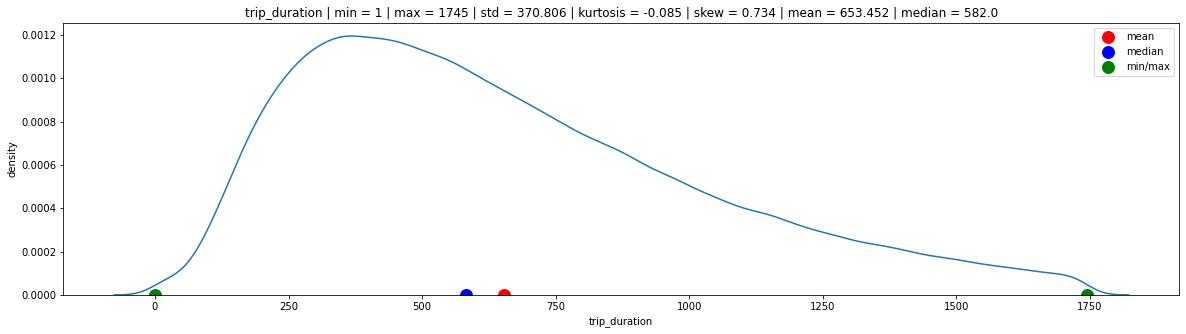

In [21]:
for i in cont_cols:
    uni_cont(df[[i]])

#### PASSENGER COUND BASED FEATURES

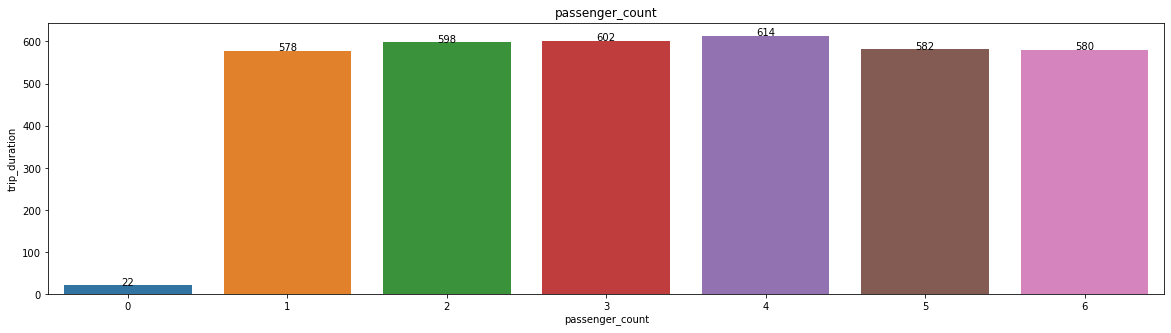

In [22]:
cat_cont(df[['trip_duration','passenger_count']])

In [9]:
df['passenger_count_0/1'] = df['passenger_count'].apply(lambda x: 0 if x == 0 else 1)

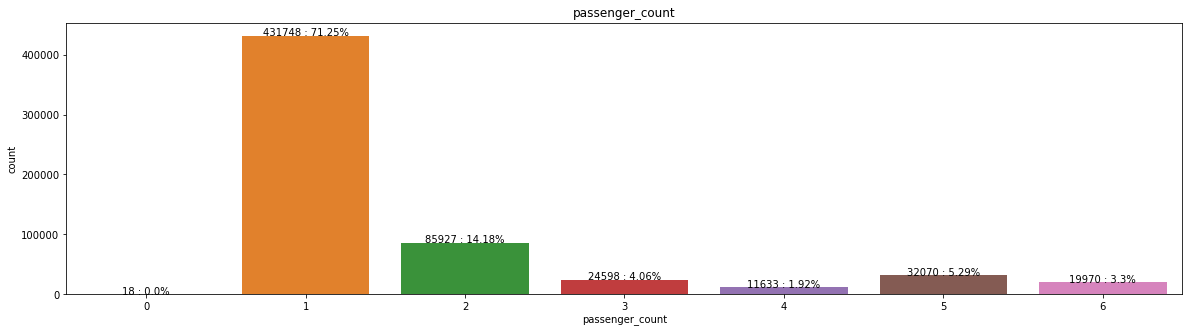

In [24]:
uni_cat(df[['id', 'passenger_count']])

In [10]:
df['passenger_count_by_count'] = df['passenger_count'].map({0:0, 1:2, 2:1, 3:0, 4:0, 5:0, 6:0})

#### DISTANCE

In [11]:
dlon = df["pickup_longitude"] - df["dropoff_longitude"]
dlat = df["pickup_latitude"] - df["dropoff_latitude"]
a = (np.sin(dlat/2))**2 + np.cos(df["pickup_latitude"]) * np.cos(df["dropoff_latitude"]) * (np.sin(dlon/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
df["distance"] = 6373.0 * c

<Figure size 1440x360 with 0 Axes>

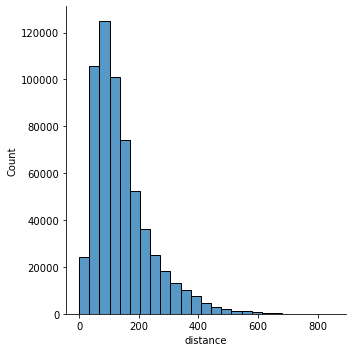

In [27]:
plt.figure(figsize=(20, 5))
sns.displot(df['distance'], kde = False, bins = 25)
plt.show()

<Figure size 1440x360 with 0 Axes>

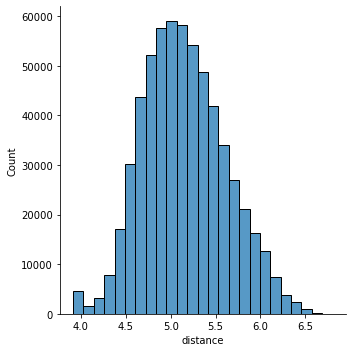

In [28]:
plt.figure(figsize=(20, 5))
sns.displot(np.log(df['distance']+50), kde = False, bins = 25)
plt.show()

In [12]:
df['l50distance'] = np.log(df['distance']+50)

#### ONE HOT ENCODE

In [13]:
df['vendor_id'] = df['vendor_id'] - 1

#### TIME BASED FEATURES

In [14]:
df['pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_week_hour'] = df['day_of_week'] * 24 + df['hour_of_day']

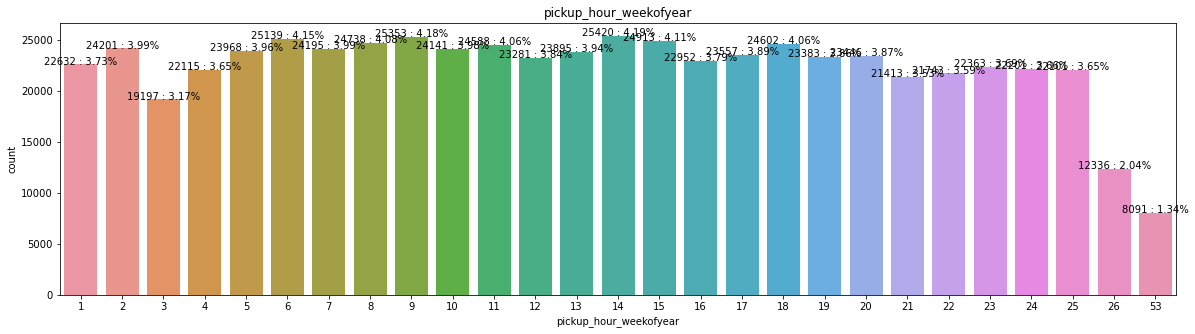

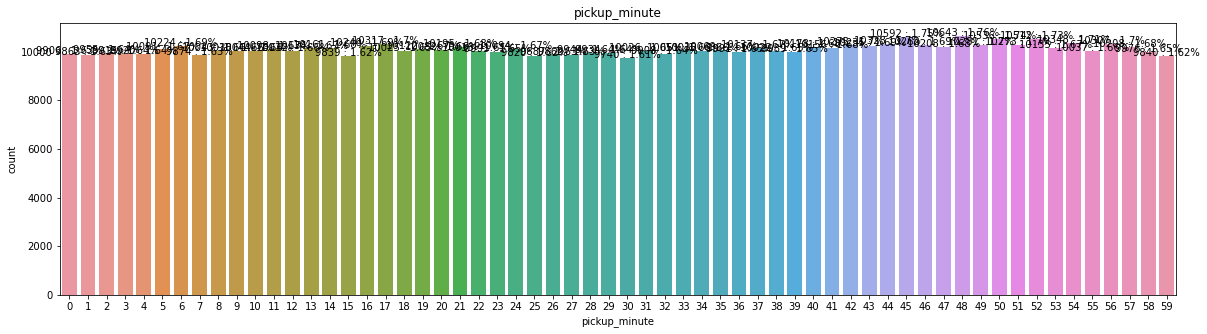

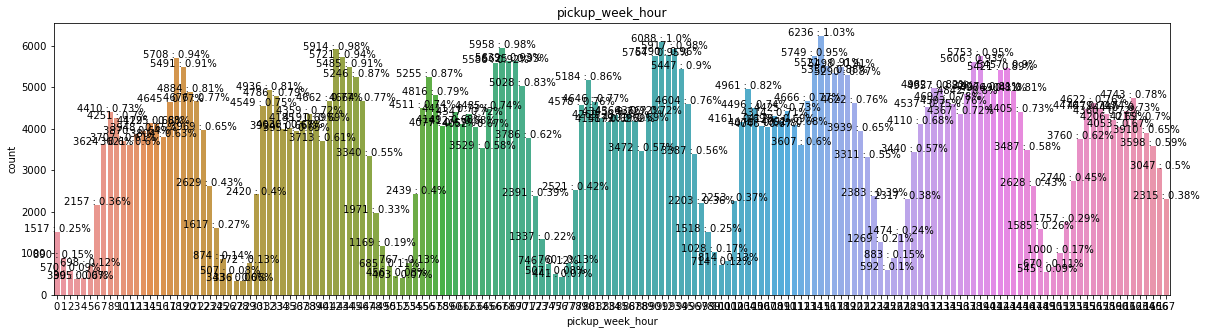

In [32]:
for i in ['pickup_hour_weekofyear', 'pickup_minute', 'pickup_week_hour']:
    uni_cat(df[['id', i]])

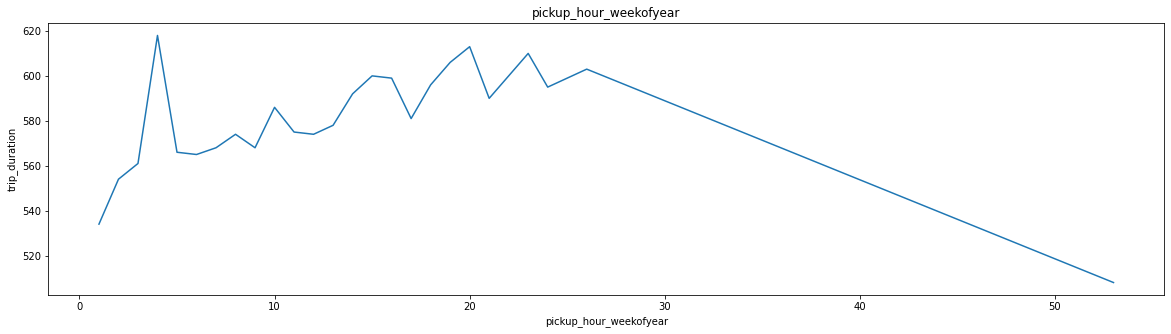

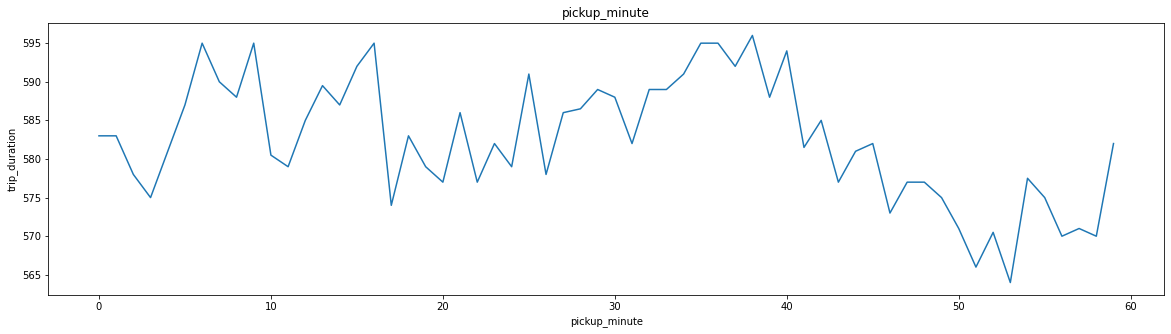

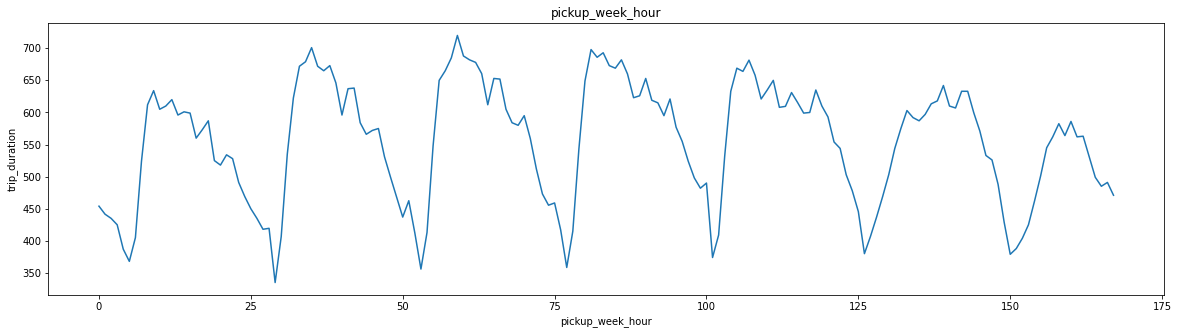

In [33]:
for i in ['pickup_hour_weekofyear', 'pickup_minute', 'pickup_week_hour']:
    date_based_cont(df[["trip_duration", i]])

In [15]:
df['day_of_week_based_level'] = df['day_of_week'].apply(lambda x: 0 if x in [0, 6] else 1)

#### BINNING

In [16]:
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)
df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

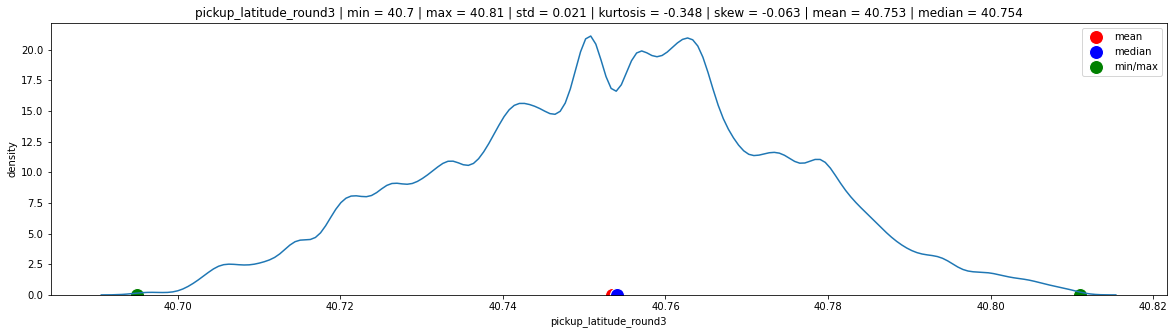

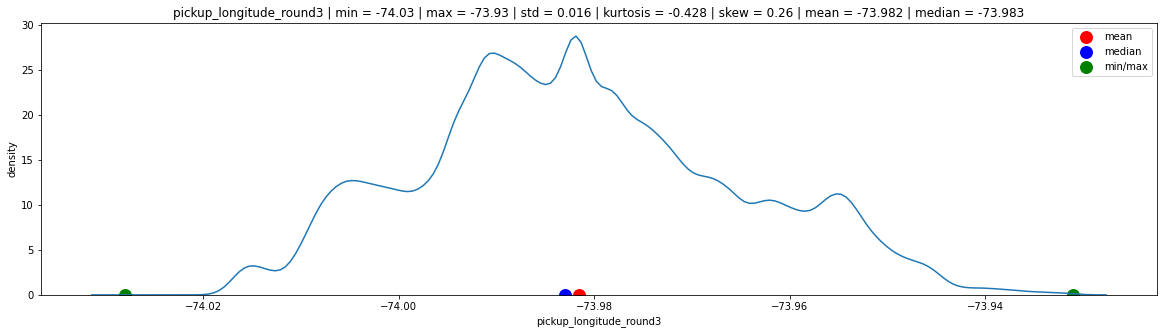

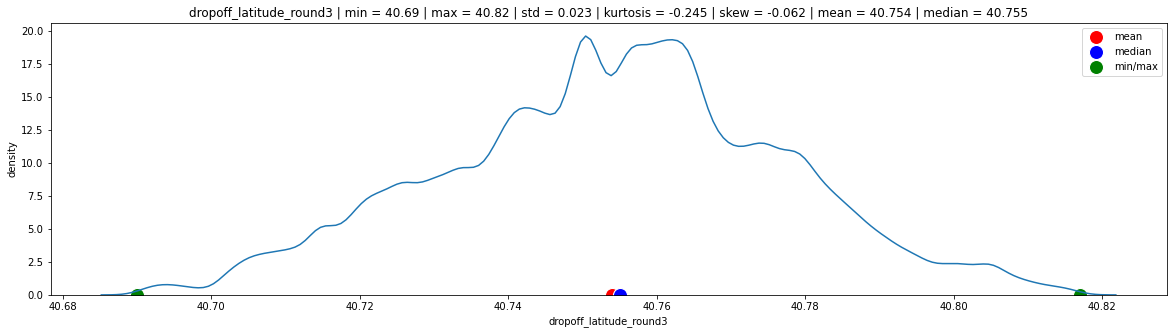

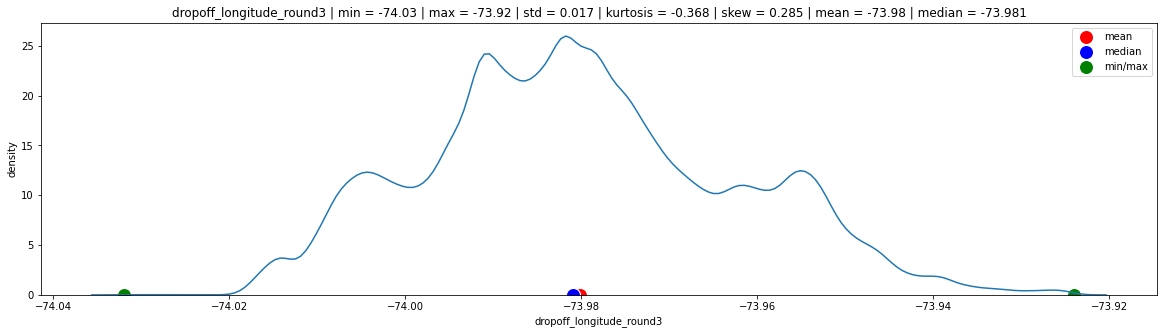

In [36]:
for i in ['pickup_latitude_round3', 'pickup_longitude_round3', 'dropoff_latitude_round3', 'dropoff_longitude_round3']:
    uni_cont(df[[i]])

In [17]:
df.reset_index(inplace = True)

In [18]:
df.columns

Index(['index', 'id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'month', 'day_of_week',
       'hour_of_day', 'passenger_count_0/1', 'passenger_count_by_count',
       'distance', 'l50distance', 'pickup_hour_weekofyear', 'pickup_minute',
       'pickup_week_hour', 'day_of_week_based_level', 'pickup_latitude_round3',
       'pickup_longitude_round3', 'dropoff_latitude_round3',
       'dropoff_longitude_round3'],
      dtype='object')

# 6. FEATURE SELECTION

#### CORRELATION

In [39]:
cont_cols = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'trip_duration',
    'distance', 'l50distance',
    'pickup_latitude_round3','pickup_longitude_round3', 'dropoff_latitude_round3','dropoff_longitude_round3'
]

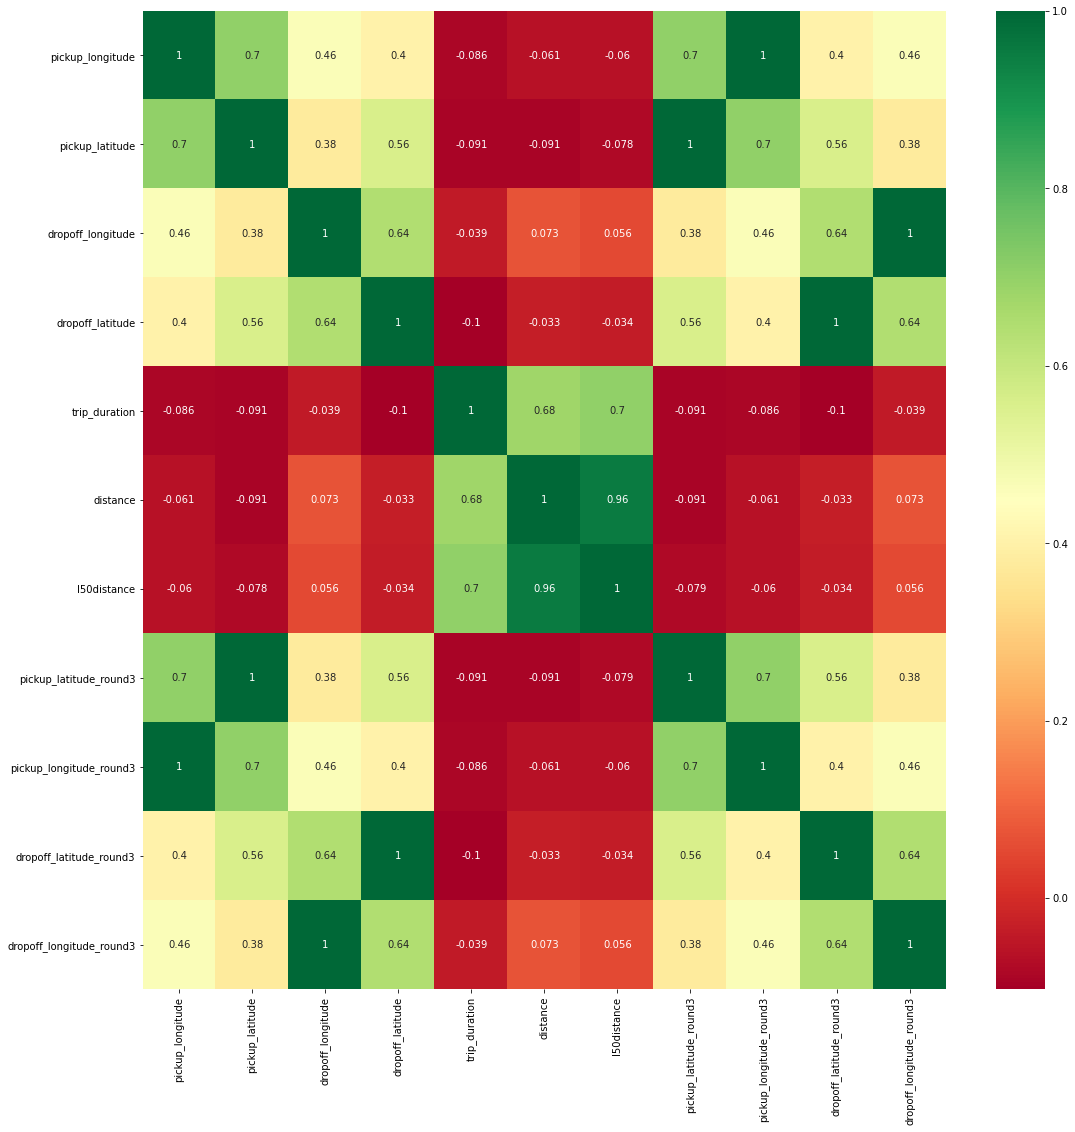

In [40]:
plt.figure(figsize = (18,18))
corr = df[cont_cols].dropna().corr()
sns.heatmap(corr, annot = True, cmap = "RdYlGn")
plt.show()

In [41]:
# HIGHLY CORRELATED FEATURES
hc = []
for i in corr:
    for j in corr:
        if abs(corr[i][j]) > 0.7 and abs(corr[i][j]) < 1:
            hc.append(" ".join(sorted([i, j])))
hc = list(set(hc))
hc

['dropoff_latitude dropoff_latitude_round3',
 'dropoff_longitude dropoff_longitude_round3',
 'pickup_latitude pickup_latitude_round3',
 'pickup_latitude pickup_longitude',
 'pickup_latitude pickup_longitude_round3',
 'l50distance trip_duration',
 'pickup_longitude pickup_longitude_round3',
 'pickup_latitude_round3 pickup_longitude',
 'pickup_latitude_round3 pickup_longitude_round3',
 'distance l50distance']

#### FEATURE IMPORTANCE

In [42]:
X = df.drop(['id', 'trip_duration', 'pickup_datetime'], axis=1)

In [43]:
y = df['trip_duration']

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.9, random_state=0)

In [45]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [46]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 2000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=100)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[00:04:07] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[00:04:07] WARNING: ..\src\learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:715.50452	valid-rmse:717.87018
[100]	train-rmse:215.80067	valid-rmse:218.85153
[200]	train-rmse:204.80464	valid-rmse:210.42848
[300]	train-rmse:199.17487	valid-rmse:206.96886
[400]	train-rmse:194.08447	valid-rmse:203.80222
[500]	train-rmse:190.77940	valid-rmse:202.15926
[600]	train-rmse:187.49194	valid-rmse:200.66891
[700]	train-rmse:184.77431	valid-rmse:199.58490
[800]	train-rmse:182.24745	valid-rmse:198.75638
[900]	train-rmse:179.98956	valid-rmse:198.05005
[1000]	train-rmse:178.01270	valid-rmse

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

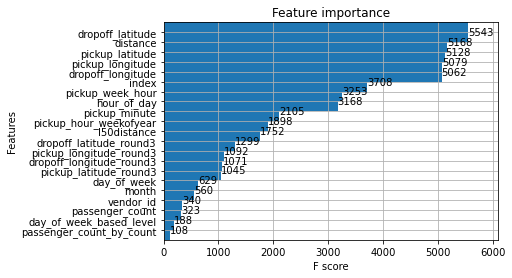

In [47]:
xgb.plot_importance(xgb_model, height=2)

In [19]:
cols = [
    'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
    'hour_of_day',
    'distance',
    'pickup_hour_weekofyear','pickup_minute','pickup_week_hour',
]

# 7. MODEL SELECTION

In [49]:
def cv_score(ml_model, cols):
    i = 1
    cv_scores = []
    
    kf = KFold(n_splits=5, random_state=11, shuffle=True)
    for train_index, test_index in kf.split(df[cols], df['trip_duration']):
        print('\n{} of kfold {}'.format(i, kf.n_splits))
        xtr,xvl = df[cols].loc[train_index], df[cols].loc[test_index]
        ytr,yvl = df['trip_duration'][train_index], df['trip_duration'][test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = math.sqrt(mean_squared_error(ytr, train_val))
        rmse_score = math.sqrt(mean_squared_error(yvl, pred_val))
        r2_score_train = r2_score(ytr, train_val)
        r2_score_test = r2_score(yvl, pred_val)
        msg = "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        
        msg += " Train r2: {:.5f} ".format(r2_score_train)
        msg += "Valid r2: {:.5f}".format(r2_score_test)
        
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

### LINEAR REGRESSION

In [50]:
linreg_scores = cv_score(LinearRegression(), cols)


1 of kfold 5
Train RMSE: 267.36550 Valid RMSE: 268.39990 Train r2: 0.47930 Valid r2: 0.47928

2 of kfold 5
Train RMSE: 267.46686 Valid RMSE: 267.99615 Train r2: 0.47942 Valid r2: 0.47880

3 of kfold 5
Train RMSE: 267.71088 Valid RMSE: 267.01845 Train r2: 0.47918 Valid r2: 0.47978

4 of kfold 5
Train RMSE: 267.77151 Valid RMSE: 266.77615 Train r2: 0.47926 Valid r2: 0.47945

5 of kfold 5
Train RMSE: 267.54509 Valid RMSE: 267.68283 Train r2: 0.47934 Valid r2: 0.47911


### DECISION TREE

In [51]:
dtree_scores = cv_score(DecisionTreeRegressor(
    criterion='mse',
    splitter='best',
    max_depth=200,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    ccp_alpha=0.0,

), cols)


1 of kfold 5
Train RMSE: 0.00000 Valid RMSE: 284.14648 Train r2: 1.00000 Valid r2: 0.41639

2 of kfold 5
Train RMSE: 0.00000 Valid RMSE: 282.48525 Train r2: 1.00000 Valid r2: 0.42092

3 of kfold 5
Train RMSE: 0.00000 Valid RMSE: 284.09217 Train r2: 1.00000 Valid r2: 0.41112

4 of kfold 5
Train RMSE: 0.00000 Valid RMSE: 282.73003 Train r2: 1.00000 Valid r2: 0.41533

5 of kfold 5
Train RMSE: 0.00000 Valid RMSE: 284.50639 Train r2: 1.00000 Valid r2: 0.41158


### RANDOM FOREST

In [52]:
rf_params = {
    'random_state': 0, 
    'n_estimators': 19, 
    'max_depth': 11, 
    'n_jobs': -1, 
    "min_samples_split": 43
}
rf_scores = cv_score(RandomForestRegressor(**rf_params), cols)


1 of kfold 5
Train RMSE: 212.41566 Valid RMSE: 217.78370 Train r2: 0.67134 Valid r2: 0.65716

2 of kfold 5
Train RMSE: 212.72327 Valid RMSE: 216.99373 Train r2: 0.67071 Valid r2: 0.65831

3 of kfold 5
Train RMSE: 212.76140 Valid RMSE: 216.55724 Train r2: 0.67104 Valid r2: 0.65782

4 of kfold 5
Train RMSE: 212.73444 Valid RMSE: 216.46384 Train r2: 0.67132 Valid r2: 0.65728

5 of kfold 5
Train RMSE: 212.58539 Valid RMSE: 216.85191 Train r2: 0.67128 Valid r2: 0.65815


### XGBOOST

In [53]:
X = df[cols]

In [54]:
y = df['trip_duration']

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.9, random_state=0)

In [56]:
parameters = {'nthread': -1,
              'objective':'reg:squarederror',
              'max_depth': 10,
              'min_child_weight': 4,
              'silent': 1,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 1000,
             }


In [57]:
xgb_model = xgb.XGBRegressor(**parameters, verbosity = 1)

In [58]:
xgb_model.fit(xtrain, ytrain)

[00:11:47] WARNING: ..\src\learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [59]:
train_val = xgb_model.predict(xtrain)
pred_val = xgb_model.predict(xtest)
rmse_score_train = math.sqrt(mean_squared_error(ytrain, train_val))
rmse_score = math.sqrt(mean_squared_error(ytest, pred_val))
r2_score_train = r2_score(ytrain, train_val)
r2_score_test = r2_score(ytest, pred_val)
msg = "Train RMSE: {:.5f} ".format(rmse_score_train)
msg += "Valid RMSE: {:.5f}".format(rmse_score)
msg += " Train r2: {:.5f} ".format(r2_score_train)
msg += "Valid r2: {:.5f}".format(r2_score_test)
print(msg)

Train RMSE: 4.61734 Valid RMSE: 215.64422 Train r2: 0.99984 Valid r2: 0.66187


### CATBOOST

In [20]:
X = df[cols]

In [21]:
X.dtypes

pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
hour_of_day                 int64
distance                  float64
pickup_hour_weekofyear      int64
pickup_minute               int64
pickup_week_hour            int64
dtype: object

In [61]:
y = df['trip_duration']

In [62]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.9, random_state=0)

In [63]:
cb_model = CatBoostRegressor(iterations=2000,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100,
                             task_type="GPU",
                             devices='0:1'
                            )

In [64]:
cb_model.fit(
    xtrain, ytrain,
    eval_set=(xtest, ytest),
    #cat_features=[4, 6, 7, 8],
    use_best_model=True,
    verbose=True
)

0:	learn: 366.1173851	test: 366.5709859	best: 366.5709859 (0)	total: 721ms	remaining: 24m
75:	learn: 232.8356868	test: 234.9578957	best: 234.9578957 (75)	total: 7.2s	remaining: 3m 2s
150:	learn: 211.7650177	test: 215.9295621	best: 215.9295621 (150)	total: 13.6s	remaining: 2m 46s
225:	learn: 202.8673668	test: 209.3591709	best: 209.3591709 (225)	total: 20.1s	remaining: 2m 37s
300:	learn: 196.5315028	test: 205.3156020	best: 205.3156020 (300)	total: 26.6s	remaining: 2m 30s
375:	learn: 191.6534708	test: 202.8545846	best: 202.8545846 (375)	total: 33.2s	remaining: 2m 23s
450:	learn: 187.3504283	test: 200.8064526	best: 200.8064526 (450)	total: 39.8s	remaining: 2m 16s
525:	learn: 183.6070103	test: 199.3491421	best: 199.3491421 (525)	total: 46.4s	remaining: 2m 10s
600:	learn: 180.0180626	test: 198.1849215	best: 198.1849215 (600)	total: 53.1s	remaining: 2m 3s
675:	learn: 176.8585627	test: 197.2099462	best: 197.2099462 (675)	total: 59.8s	remaining: 1m 57s
750:	learn: 173.7242252	test: 196.4918999	

In [65]:
train_val = cb_model.predict(xtrain)
pred_val = cb_model.predict(xtest)
rmse_score_train = math.sqrt(mean_squared_error(ytrain, train_val))
rmse_score = math.sqrt(mean_squared_error(ytest, pred_val))
r2_score_train = r2_score(ytrain, train_val)
r2_score_test = r2_score(ytest, pred_val)
msg = "Train RMSE: {:.5f} ".format(rmse_score_train)
msg += "Valid RMSE: {:.5f}".format(rmse_score)
msg += " Train r2: {:.5f} ".format(r2_score_train)
msg += "Valid r2: {:.5f}".format(r2_score_test)
print(msg)

Train RMSE: 137.75217 Valid RMSE: 192.40259 Train r2: 0.86171 Valid r2: 0.73083


<Figure size 1440x360 with 0 Axes>

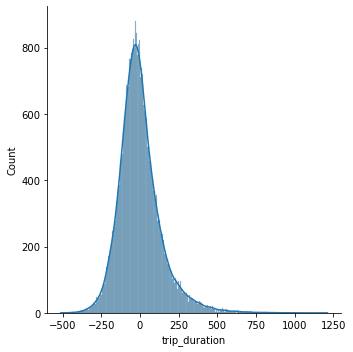

In [66]:
plt.figure(figsize=(20, 5))
sns.displot(ytrain - train_val, kde = True, bins = 500)
plt.show()

<Figure size 1440x360 with 0 Axes>

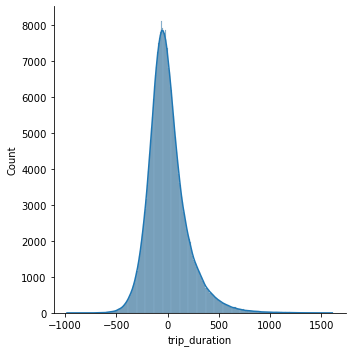

In [67]:
plt.figure(figsize=(20, 5))
sns.displot(ytest - pred_val, kde = True, bins = 500)
plt.show()

In [68]:
cb_model.save_model('cb_model') 

ERRORS ARE NORMALLY DISTRIBUTED

### NEURAL NETWORK

In [ ]:
import torch.nn as nn
import torch

In [ ]:
class Regressior(nn.Module):
    def __init__(self):
        super(Regressior, self).__init__()
        self.f1 = nn.Linear(17,256)
        self.f2 = nn.Linear(256,128)
        self.f3 = nn.Linear(128,1)
        self.relu = nn.ReLU()
    def forward(self, input1):
        x = self.f1(input1)
        x = self.relu(x)
        x = self.f2(x)
        x = self.relu(x)
        x = self.f3(x)
        return x

In [ ]:
model = Regressior().to('cuda')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
def train():
    print("\nTraining.....")
    model.train()
    X = torch.tensor(df[cols1].values, dtype=torch.float).cuda()
    y = torch.tensor(df["trip_duration"].values, dtype=torch.float).cuda()
    model.zero_grad()
    preds = model(X)
    loss = nn.functional.mse_loss(preds.squeeze(), y)
    loss.backward()
    optimizer.step()
    print("R2 SCORE {}".format(r2_score(y.detach().cpu().numpy(), preds.detach().cpu().squeeze().numpy())))

In [ ]:
def validate():
    print("\nValidation.....")
    model.eval()
    total_preds=[]
    indices = np.random.permutation(df.shape[0])
    for i in range(0, df.shape[0], 32):
        ind = indices[i: i + 32]
        batch_x = torch.tensor(df.iloc[ind][cols1].values, dtype=torch.float).cuda()
        batch_y = torch.tensor(df.iloc[ind]["trip_duration"].values, dtype=torch.float).cuda()
        #batch_x = torch.tensor(t.to(device) for t in batch_x)
        #batch_y = torch.tensor(t.to(device) for t in batch_y)
        model.zero_grad()
        preds = model(batch_x)
        loss = nn.functional.mse_loss(preds.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        preds = preds.detach().cpu().squeeze().numpy()
        total_preds.extend(preds)
        if (i%10000==0):
            print(r2_score(batch_y.detach().cpu().numpy(), preds))
    return total_preds

In [ ]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]
epochs = 1000
for epoch in range(epochs):
    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))
    train()